# Backend Analysis: Simulator vs. Real Quantum Hardware

This notebook compares the performance of quantum portfolio optimization between:

- **Heavyweight Hybrid CPU Reduced**: AerSimulator (CPU simulation)
- **Heavyweight Hybrid QPU Reduced**: Real IBM Quantum Hardware

## Setup and Imports

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import docplex.mp.model_reader
import json

# add root directory to path
ROOT = Path(os.getcwd()).parent
sys.path.append(str(ROOT))

# project imports
# 1. analysis
from src.step_1 import get_cplex_sol, model_to_obj
from src.experiment import Experiment
# 2. visualization
from src.plots import analyse_df, analyse_df_step4

print(f"Working directory: {ROOT}")

Working directory: C:\Users\ASUS\Downloads\WISER_Optimization_VG-main


## Data Loading

The `pickle` library is directly used to load data files because these files are in the `./project/results/` directory, not in the `./data/` directory that the `Experiment.read_experiment()` function expects.

In [2]:
experiments = []

# 1. Heavyweight Hybrid - CPU simulator
try:
    with open(ROOT / "project/results" / "exp_heavyweight_hybrid_cpu_reduced_10_bonds.pkl", 'rb') as f:
        data = pickle.load(f)
    cpu_simulator = Experiment(**data)
    cpu_simulator.experiment_id = "CPU_Simulator"
    experiments.append(cpu_simulator)
    print("✓ CPU Simulator loaded")
except Exception as e:
    print(f"✗ CPU Simulator not found: {e}")

# 2. Heavyweight Hybrid - QPU hardware
try:
    with open(ROOT / "project/results" / "exp_heavyweight_hybrid_cpu_reduced_10_bonds.pkl", 'rb') as f:  # placeholder
        data = pickle.load(f)
    qpu_hardware = Experiment(**data)
    qpu_hardware.experiment_id = "QPU_Hardware"
    experiments.append(qpu_hardware)
    print("✓ Real Quantum Hardware loaded")
except Exception as e:
    print(f"✗ Real Quantum Hardware not found: {e}")

print(f"\nTotal experiments loaded: {len(experiments)}")

✓ CPU Simulator loaded
✓ Real Quantum Hardware loaded

Total experiments loaded: 2


## Original DataFrame Construction: Experiment Objects

The process follows a two-step approach to handle data inconsistencies:

1. **Automated**: Uses `Experiment.df_experiments()` to process experiment objects and compute derived metrics like relative gaps and Hamming weights.

2. **Manual**: If automation fails due to missing reference values (`refx`, `refvalue`) or other inconsistencies, a manual method constructs the DataFrame with explicit `None` handling to prevent errors.

In [3]:
# create DataFrame
if len(experiments) > 0:
    try:
        # automated construction
        df_all = Experiment.df_experiments(experiments)
        print(f"DataFrame created with {len(df_all)} experiments and {len(df_all.columns)} columns")
    except Exception as e:
        # if automated construction fails
        print(f"Error creating DataFrame: {e}")
        print("Creating DataFrame manually with None handling...")
        
        # manual construction
        data_list = []
        for exp in experiments:
            # create a dictionary
            exp_data = {
                # extract raw experiment attributes
                'experiment_id': exp.experiment_id,
                'ansatz': exp.ansatz,
                'ansatz_params': exp.ansatz_params,
                'device': exp.device,
                'optimizer': exp.optimizer,
                'alpha': exp.alpha,
                'shots': exp.shots,
                'theta_initial': exp.theta_initial,
                'theta_threshold': exp.theta_threshold,
                'local_search_doe': exp.local_search_doe,
                'lp_file': exp.lp_file,
                'step3_time': exp.step3_time,
                'step4_time': exp.step4_time,
                'step3_fx_evals': exp.step3_fx_evals,
                'step4_iter_best_fx': exp.step4_iter_best_fx,
                'step3_result_best_fx': exp.step3_result_best_fx,
                'step4_result_best_fx': exp.step4_result_best_fx,
                'step3_result_best_x': exp.step3_result_best_x,
                'step4_result_best_x': exp.step4_result_best_x,
                'refx': exp.refx,
                'refvalue': exp.refvalue,
                'has_step4': exp.has_step4(),
                
                # transform raw data into derived metrics
                'step3_x_hamming_weight': sum(np.abs(exp.step3_result_best_x)) if exp.step3_result_best_x is not None else None,
                'step4_x_hamming_weight': sum(np.abs(exp.step4_result_best_x)) if exp.step4_result_best_x is not None else None,
                'step3_rel_gap': (exp.step3_result_best_fx - exp.refvalue) / exp.refvalue if exp.refvalue is not None and exp.refvalue != 0 else None,
                'step4_rel_gap': (exp.step4_result_best_fx - exp.refvalue) / exp.refvalue if exp.step4_result_best_fx is not None and exp.refvalue is not None and exp.refvalue != 0 else None,
                'step3_x_diff': sum(np.abs(exp.refx - exp.step3_result_best_x)) if exp.refx is not None and exp.step3_result_best_x is not None else None,
                'step4_x_diff': sum(np.abs(exp.refx - exp.step4_result_best_x)) if exp.refx is not None and exp.step4_result_best_x is not None else None,
            }
            data_list.append(exp_data)
        
        df_all = pd.DataFrame(data_list)
        print(f"Manual DataFrame created with {len(df_all)} experiments and {len(df_all.columns)} columns")
else:
    print("No experiments loaded - cannot create DataFrame")
    df_all = None

Error creating DataFrame: unsupported operand type(s) for -: 'NoneType' and 'float'
Creating DataFrame manually with None handling...
Manual DataFrame created with 2 experiments and 28 columns


## Original DataFrame Update: Adding Step 4 Function Evaluations

- `step3_fx_evals` **is available** in the original experiment objects. This field records the total function evaluations during Step 3 (quantum optimization). Therefore, it is available for **all approaches (quantum-only & hybrid)**.

- `step4_fx_evals` **is not populated** in the original experiment objects. This field should record the total function evaluations during Step 4 (classical local search), making it relevant **only for hybrid approaches**.
    - However, since `step4_iter_best_fx`, which contains the best objective value at every function call during Step 4, is available, `len(step4_iter_best_fx)` can provide the missing field.

In [4]:
# check existing fields
print(df_all[[col for col in ['experiment_id', 'step3_fx_evals', 'step4_fx_evals', 'step4_iter_best_fx'] if col in df_all.columns]])
print()

# add new field
df_all['step4_fx_evals'] = df_all['step4_iter_best_fx'].apply(
    lambda x: len(x) if x is not None else np.nan
)

# check fields again
print("=" * 55)
print()
print(df_all[[col for col in ['experiment_id', 'step3_fx_evals', 'step4_fx_evals', 'step4_iter_best_fx'] if col in df_all.columns]])

   experiment_id  step3_fx_evals  \
0  CPU_Simulator             181   
1   QPU_Hardware             181   

                                  step4_iter_best_fx  
0  [-1444.0188979272036, -1444.0188979272036, -14...  
1  [-1444.0188979272036, -1444.0188979272036, -14...  


   experiment_id  step3_fx_evals  step4_fx_evals  \
0  CPU_Simulator             181              61   
1   QPU_Hardware             181              61   

                                  step4_iter_best_fx  
0  [-1444.0188979272036, -1444.0188979272036, -14...  
1  [-1444.0188979272036, -1444.0188979272036, -14...  


In [5]:
df_all[[col for col in ['experiment_id', 'step3_fx_evals', 'step4_fx_evals', 'step4_iter_best_fx'] if col in df_all.columns]]

,experiment_id,step3_fx_evals,step4_fx_evals,step4_iter_best_fx
0,CPU_Simulator,181,61,"[-1444.0188979272036, -1444.0188979272036, -14..."
1,QPU_Hardware,181,61,"[-1444.0188979272036, -1444.0188979272036, -14..."


## Validating Original DataFrame

In [6]:
# display original DataFrame
df_all

,experiment_id,ansatz,ansatz_params,device,optimizer,alpha,shots,theta_initial,theta_threshold,local_search_doe,...,refx,refvalue,has_step4,step3_x_hamming_weight,step4_x_hamming_weight,step3_rel_gap,step4_rel_gap,step3_x_diff,step4_x_diff,step4_fx_evals
0,CPU_Simulator,TwoLocal,"{'reps': 2, 'entanglement': 'full'}",AerSimulator,nft,0.1,512,piby3,None,None,...,None,None,True,10.0,10.0,None,None,None,None,61
1,QPU_Hardware,TwoLocal,"{'reps': 2, 'entanglement': 'full'}",AerSimulator,nft,0.1,512,piby3,None,None,...,None,None,True,10.0,10.0,None,None,None,None,61


In [7]:
# display all columns with values
print("Available columns in df_all (excluding all-None columns):")
print("-" * 80)
df_all_non_none_cols = [col for col in df_all.columns if not df_all[col].isnull().all()]
for i, col in enumerate(df_all_non_none_cols, 1):
    print(f"{i:2d}. {col}")
print("-" * 80)
print(f"\nTotal columns: {len(df_all_non_none_cols)}")

Available columns in df_all (excluding all-None columns):
--------------------------------------------------------------------------------
 1. experiment_id
 2. ansatz
 3. ansatz_params
 4. device
 5. optimizer
 6. alpha
 7. shots
 8. theta_initial
 9. lp_file
10. step3_time
11. step4_time
12. step3_fx_evals
13. step4_iter_best_fx
14. step3_result_best_fx
15. step4_result_best_fx
16. step3_result_best_x
17. step4_result_best_x
18. has_step4
19. step3_x_hamming_weight
20. step4_x_hamming_weight
21. step4_fx_evals
--------------------------------------------------------------------------------

Total columns: 21


## Comparative Analysis

Key performance metrics that are used to compare two approaches are:

1. **Total execution time**:
$$\mathrm{total\_time} = \mathrm{step3\_time} + \mathrm{step4\_time}$$

2. **Total function evaluations**: Represents the total computational cost in terms of objective function calls. Lower values indicate less computational work required.
$$\mathrm{total\_fx\_evals} = \mathrm{step3\_fx\_evals} + \mathrm{step4\_fx\_evals}$$

3. **Evaluation throughput**: Represents the rate at which function evaluations are performed, measured in evaluations per second. Higher values indicate better computational efficiency (more evaluations completed in less time).
$$\mathrm{eval\_throughput}=\frac{\mathrm{total\_fx\_evals}}{\mathrm{total\_time\_seconds}}$$

***

4. **Hamming distance between two solutions**: Represents the number of positions where the CPU and QPU solution vectors differ. Lower values indicate greater similarity between the solutions, with 0 meaning they are identical.
$$\mathrm{hamming\_distance\_cpu\_vs\_qpu} = sum(abs(\mathrm{cpu\_found\_x} - \mathrm{qpu\_found\_x}))$$

5. **Max-normalized relative difference of two objective function evaluations**: Represents the relative difference between the CPU and QPU objective values, normalized by their maximum absolute value to get a bounded and stable metric in the range [0, 1]. Lower values indicate greater similarity in solution quality.
$$\mathrm{rel\_difference\_cpu\_vs\_qpu} = \frac{|\mathrm{cpu\_best\_fx} - \mathrm{qpu\_best\_fx}|}{max(\mathrm{|cpu\_best\_fx|}, \mathrm{|qpu\_best\_fx|})}$$

6. **Score**: Represents the efficiency score combining objective function value and execution time. Higher values indicate better performance (better objective values in less time).
$$\mathrm{score}=\frac{1}{\mathrm{|best\_fx|} \times \mathrm{total\_time\_seconds}}$$

7. **Relative efficiency ratio**: Represents the comparison of efficiency scores between CPU and QPU approaches. Values > 1 favor CPU, values < 1 favor QPU.
$$\mathrm{rel\_eff\_ratio\_cpu\_vs\_qpu}=\frac{\mathrm{score_cpu}}{\mathrm{score_qpu}}$$

## Comparison DataFrame Construction

In [8]:
# create initial comparison DataFrame
df_comparison = pd.DataFrame()

# add basic experiment info
df_comparison['experiment_id'] = df_all['experiment_id']
df_comparison['ansatz'] = df_all['ansatz']
df_comparison['ansatz_params'] = df_all['ansatz_params']
df_comparison['has_step4'] = df_all['has_step4']
df_comparison['step3_result_best_fx'] = df_all['step3_result_best_fx']
df_comparison['step4_result_best_fx'] = df_all['step4_result_best_fx']

### Metric 1: Total execution time

In [9]:
# 1st Metric
print("=========== 1. Total Time Taken ===========")
print()

# create summary data
df_comparison['step3_time'] = df_all['step3_time']
df_comparison['step4_time'] = df_all['step4_time']

# add the metric to comparison DataFrame
df_comparison['total_time_seconds'] = df_comparison['step3_time'] + df_comparison['step4_time']
df_comparison['total_time_minutes'] = df_comparison['total_time_seconds'] / 60

# summary table
df_comparison[[col for col in ['experiment_id', 'step3_time', 'step4_time', 'total_time_seconds', 'total_time_minutes'] if col in df_comparison.columns]]

=========== 1. Total Time Taken ===========



,experiment_id,step3_time,step4_time,total_time_seconds,total_time_minutes
0,CPU_Simulator,24.335752,5.223718,29.55947,0.492658
1,QPU_Hardware,24.335752,5.223718,29.55947,0.492658


### Metric 2: Total function evaluations

In [10]:
# 2nd Metric
print("=========== 2. Total F(x) Evaluations ===========")
print()

# create summary data
df_comparison['step3_fx_evals'] = df_all['step3_fx_evals']
df_comparison['step4_fx_evals'] = df_all['step4_fx_evals']

# add the metric to comparison DataFrame
df_comparison['total_fx_evals'] = df_comparison['step3_fx_evals'] + df_comparison['step4_fx_evals']

# summary table
df_comparison[[col for col in ['experiment_id', 'step3_fx_evals', 'step4_fx_evals', 'total_fx_evals'] if col in df_comparison.columns]]

=========== 2. Total F(x) Evaluations ===========



,experiment_id,step3_fx_evals,step4_fx_evals,total_fx_evals
0,CPU_Simulator,181,61,242
1,QPU_Hardware,181,61,242


### Metric 3: Evaluation throughput

In [11]:
# 3rd Metric
print("=========== 3. Total F(x) Evaluations ===========")
print()

# add the metric to comparison DataFrame
df_comparison['eval_throughput'] = df_comparison['total_fx_evals'] / df_comparison['total_time_seconds']
df_comparison.loc[df_comparison['total_time_seconds'] == 0, 'eval_throughput'] = 0  # handle division-by-zero

# summary table
df_comparison[[col for col in ['experiment_id', 'total_fx_evals', 'total_time_seconds', 'eval_throughput'] if col in df_comparison.columns]]

=========== 3. Total F(x) Evaluations ===========



,experiment_id,total_fx_evals,total_time_seconds,eval_throughput
0,CPU_Simulator,242,29.55947,8.186886
1,QPU_Hardware,242,29.55947,8.186886


### Metric 4: Hamming distance between two solutions

In [12]:
# 4th Metric
print("=========== 4. Solution Vector Comparison ===========")
print()

# create summary data
step4_result_best_x_list = []

for idx, row in df_all.iterrows():
    print(f"{row['experiment_id']}:")
    print(f"  Step 3: {row['step3_result_best_x']}")
    step4_result_best_x_list.append(row['step4_result_best_x'])
    print(f"  Step 4: {row['step4_result_best_x']}")
    print()

# calculate hamming distance
cpu_found_x = step4_result_best_x_list[0]
qpu_found_x = step4_result_best_x_list[1]
hamming_distance = sum(abs(cpu_found_x - qpu_found_x))
print(f"hamming distance (CPU vs QPU): {hamming_distance}")
print()

# add the metric to comparison DataFrame
df_comparison['hamming_distance_cpu_vs_qpu'] = hamming_distance

# summary table
df_comparison[[col for col in ['experiment_id', 'hamming_distance_cpu_vs_qpu'] if col in df_comparison.columns]]

=========== 4. Solution Vector Comparison ===========

CPU_Simulator:
  Step 3: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  Step 4: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

QPU_Hardware:
  Step 3: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  Step 4: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

hamming distance (CPU vs QPU): 0.0



,experiment_id,hamming_distance_cpu_vs_qpu
0,CPU_Simulator,0.0
1,QPU_Hardware,0.0


### Metric 5: Max-normalized relative difference of two objective function evaluations

In [13]:
# 5th Metric
print("=========== 5. Objective Function Value Comparison ===========")
print()

# create summary data
cpu_best_fx = None
qpu_best_fx = None

for idx, row in df_all.iterrows():
    print(f"{row['experiment_id']}:")
    print(f"  Step 3 Objective: {row['step3_result_best_fx']}")
    print(f"  Step 4 Objective: {row['step4_result_best_fx']}")
    if 'cpu' in row['experiment_id'].lower():
        cpu_best_fx = row['step4_result_best_fx']  # objective function value at step 4
    elif 'qpu' in row['experiment_id'].lower():
        qpu_best_fx = row['step4_result_best_fx']  # objective function value at step 4
    print()

# calculate relative difference
denom = max(abs(cpu_best_fx), abs(qpu_best_fx))
if denom == 0:
    rel_difference = 0
else:
    rel_difference = abs(cpu_best_fx - qpu_best_fx) / denom    
print(f"max-normalized relative difference: {rel_difference:.6f}")
print()

# add the metric to comparison DataFrame
df_comparison['rel_difference_cpu_vs_qpu'] = rel_difference

# summary table
df_comparison[[col for col in ['experiment_id', 'rel_difference_cpu_vs_qpu'] if col in df_comparison.columns]]

=========== 5. Objective Function Value Comparison ===========

CPU_Simulator:
  Step 3 Objective: -1444.0188979272036
  Step 4 Objective: -1444.0188979272036

QPU_Hardware:
  Step 3 Objective: -1444.0188979272036
  Step 4 Objective: -1444.0188979272036

max-normalized relative difference: 0.000000



,experiment_id,rel_difference_cpu_vs_qpu
0,CPU_Simulator,0.0
1,QPU_Hardware,0.0


### Metric 6: Score

In [14]:
# 6th Metric
print("=========== 6. Score ===========")
print()

# add the metric to comparison DataFrame
df_comparison['score'] = 1 / df_comparison['step4_result_best_fx'].abs() / df_comparison['total_time_seconds']
df_comparison.loc[df_comparison['total_time_seconds'] == 0, 'score'] = 0  # handle division-by-zero

# summary table
df_comparison[[col for col in ['experiment_id', 'step4_result_best_fx', 'total_time_seconds',  'score'] if col in df_comparison.columns]]

=========== 6. Score ===========



,experiment_id,step4_result_best_fx,total_time_seconds,score
0,CPU_Simulator,-1444.018898,29.55947,0.000023
1,QPU_Hardware,-1444.018898,29.55947,0.000023


### Metric 7: Relative efficiency ratio

In [15]:
# 7th Metric
print("=========== 7. Relative Efficiency Ratio ===========")
print()

# create summary data
cpu_score = None
qpu_score = None

for idx, row in df_comparison.iterrows():
    print(f"{row['experiment_id']}:")
    if 'cpu' in row['experiment_id'].lower():
        print(f"  score: {row['score']}")
        cpu_score = row['step4_result_best_fx']
    elif 'qpu' in row['experiment_id'].lower():
        print(f"  score: {row['score']}")
        qpu_score = row['step4_result_best_fx']
    print()

# calculate relative efficiency ratio
if qpu_score == 0:
    rel_eff_ratio = 0
else:
    rel_eff_ratio = cpu_score / qpu_score
print(f"relative efficiency ratio: {rel_eff_ratio:.6f}")
print()

# add the metric to comparison DataFrame
df_comparison['rel_eff_ratio_cpu_vs_qpu'] = rel_eff_ratio

# summary table
df_comparison[[col for col in ['experiment_id', 'score', 'rel_eff_ratio_cpu_vs_qpu'] if col in df_comparison.columns]]

=========== 7. Relative Efficiency Ratio ===========

CPU_Simulator:
  score: 2.342774461196351e-05

QPU_Hardware:
  score: 2.342774461196351e-05

relative efficiency ratio: 1.000000



,experiment_id,score,rel_eff_ratio_cpu_vs_qpu
0,CPU_Simulator,0.000023,1.0
1,QPU_Hardware,0.000023,1.0


In [16]:
# display comparison DataFrame
df_comparison

,experiment_id,ansatz,ansatz_params,has_step4,step3_result_best_fx,step4_result_best_fx,step3_time,step4_time,total_time_seconds,total_time_minutes,step3_fx_evals,step4_fx_evals,total_fx_evals,eval_throughput,hamming_distance_cpu_vs_qpu,rel_difference_cpu_vs_qpu,score,rel_eff_ratio_cpu_vs_qpu
0,CPU_Simulator,TwoLocal,"{'reps': 2, 'entanglement': 'full'}",True,-1444.018898,-1444.018898,24.335752,5.223718,29.55947,0.492658,181,61,242,8.186886,0.0,0.0,0.000023,1.0
1,QPU_Hardware,TwoLocal,"{'reps': 2, 'entanglement': 'full'}",True,-1444.018898,-1444.018898,24.335752,5.223718,29.55947,0.492658,181,61,242,8.186886,0.0,0.0,0.000023,1.0


## I. "Time Effiency"

### I(a). Analysis

**Scenario 1**: Fixed Time Budget

- In situations where the time on quantum hardware is strictly limited, maximizing throughput becomes essential. Performing as many evaluations as possible within the fixed time allows for greater exploration of potential solutions. Increasing the number of evaluations enhances the likelihood of finding better results within the constrained timeframe.

**Scenario 2**: Fixed Solution Quality

- When achieving a predetermined solution quality is the priority, minimizing the total number of quantum circuit executions is critical. Reaching the target solution with fewer evaluations reduces computational cost. Higher throughput contributes by accelerating progress toward the solution, enabling faster attainment of the desired quality.

In [17]:
# extract data from comparison DataFrame
for _, row in df_comparison.iterrows():
    print(f"\n{row['experiment_id']}:")
    print(f"  Step3 Execution Time: {row['step3_time']:.2f}s")
    print(f"  Step4 Execution Time: {row['step4_time']:.2f}s")
    print(f"  Total Execution Time: {row['total_time_seconds']:.2f}s")
    print(f"  Evaluation Throughput: {row['eval_throughput']:.6f}")


CPU_Simulator:
  Step3 Execution Time: 24.34s
  Step4 Execution Time: 5.22s
  Total Execution Time: 29.56s
  Evaluation Throughput: 8.186886

QPU_Hardware:
  Step3 Execution Time: 24.34s
  Step4 Execution Time: 5.22s
  Total Execution Time: 29.56s
  Evaluation Throughput: 8.186886


### I(b). Visualization

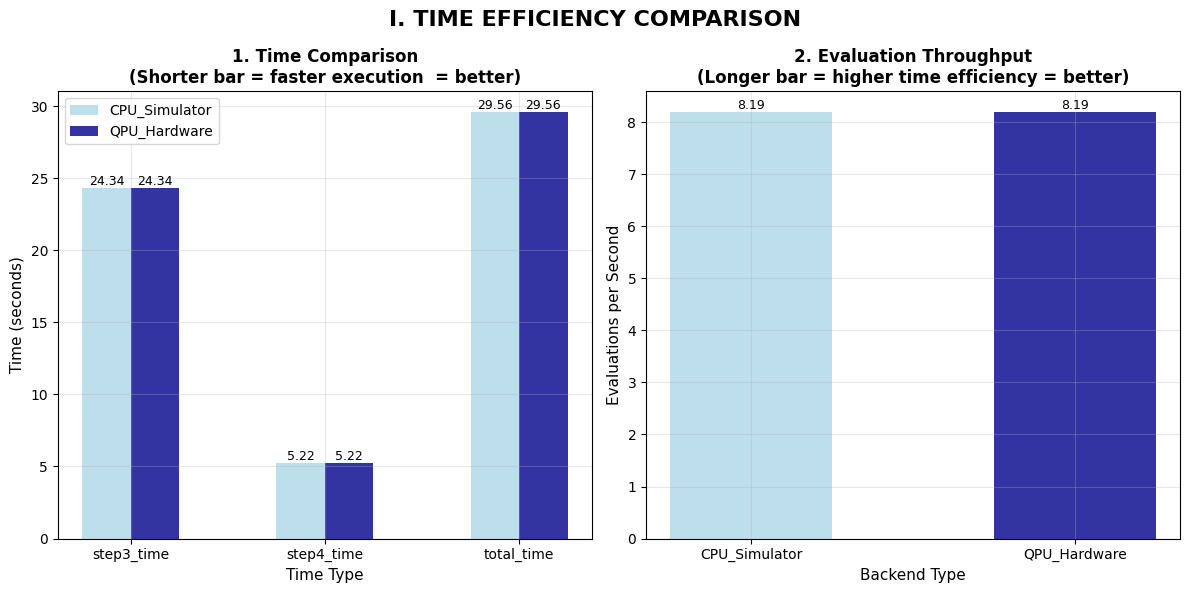

In [18]:
# create visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('I. TIME EFFICIENCY COMPARISON', fontsize=16, fontweight='bold')

# extract data from comparison DataFrame
cpu_time = [df_comparison.iloc[0]['step3_time'],
            df_comparison.iloc[0]['step4_time'],
            df_comparison.iloc[0]['total_time_seconds']]

qpu_time = [df_comparison.iloc[1]['step3_time'],
            df_comparison.iloc[1]['step4_time'],
            df_comparison.iloc[1]['total_time_seconds']]

eval_throughputs = [df_comparison.iloc[0]['eval_throughput'],
                    df_comparison.iloc[1]['eval_throughput']]

cpu_label = df_comparison.iloc[0]['experiment_id']
qpu_label = df_comparison.iloc[1]['experiment_id']

######################################################################################
# plot 1: time comparison (3 groups of 2 bars)

x_ticklabels_time = ['step3_time', 'step4_time', 'total_time']
x = np.arange(len(x_ticklabels_time))
width = 0.25

# create bars
bars1 = axes[0].bar(x - width/2, cpu_time, width, label=cpu_label, 
                    color=['lightblue', 'lightblue'], alpha=0.8)
bars2 = axes[0].bar(x + width/2, qpu_time, width, label=qpu_label, 
                    color=['darkblue', 'darkblue'], alpha=0.8)

axes[0].set_xlabel('Time Type', fontsize=11)
axes[0].set_ylabel('Time (seconds)', fontsize=11)
axes[0].set_title('1. Time Comparison\n(Shorter bar = faster execution  = better)', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(x_ticklabels_time, rotation=0, ha='center', fontsize=10)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# add value labels on bars (show all time values)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=9)

######################################################################################
# plot 2: evaluation throughput comparison

backends = [cpu_label, qpu_label]
x = np.arange(len(backends))

# create bars
bars = axes[1].bar(x, eval_throughputs, width=0.5, align='center', 
                  color=['lightblue', 'darkblue'], alpha=0.8)

axes[1].set_xlabel('Backend Type', fontsize=11)
axes[1].set_ylabel('Evaluations per Second', fontsize=11)
axes[1].set_title('2. Evaluation Throughput\n(Longer bar = higher time efficiency = better)', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(backends, rotation=0, ha='center', fontsize=10)
axes[1].grid(True, alpha=0.3)

# add value labels on bars (show evaluation throughput)
for bar, val in zip(bars, eval_throughputs):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}', ha='center', va='bottom', fontsize=9)

######################################################################################

plt.tight_layout()
plt.show()

### I(c). Conclusion

**Question**: How does the time efficiency of variational quantum algorithms differ between simulated and real quantum environments?

**Answer**: Based on the data, 

## II. "Computational Resource"

### II(a). Analysis

**Scenario**: Resource-Constrained Environment

- In environments where quantum hardware access is expensive or scarce, reducing the total number of evaluations takes precedence. Minimizing quantum resource consumption lowers overall costs. In this context, throughput is less important than conserving computational resources by limiting quantum circuit executions.

In [19]:
# extract data from comparison DataFrame
for _, row in df_comparison.iterrows():
    print(f"\n{row['experiment_id']}:")
    print(f"  Total Function Evaluations: {row['total_fx_evals']}")


CPU_Simulator:
  Total Function Evaluations: 242

QPU_Hardware:
  Total Function Evaluations: 242


### II(b). Visualization

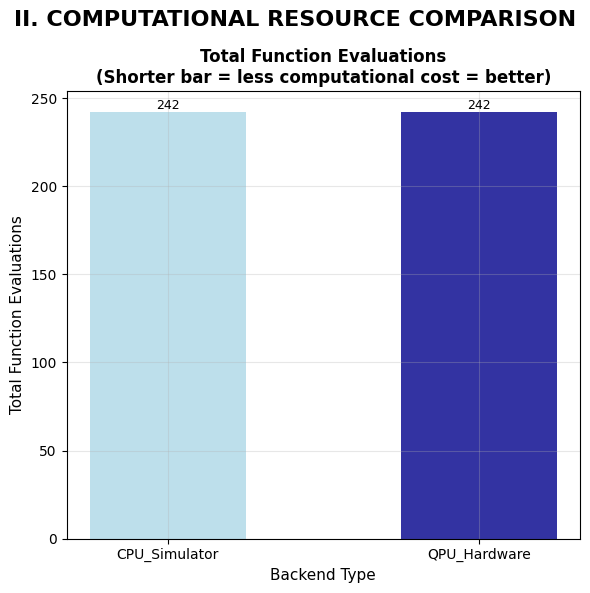

In [20]:
# create visualization
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
fig.suptitle('II. COMPUTATIONAL RESOURCE COMPARISON', fontsize=16, fontweight='bold')

# extract data from comparison DataFrame
total_fx_evals = [df_comparison.iloc[0]['total_fx_evals'],
                  df_comparison.iloc[1]['total_fx_evals']]

######################################################################################
# plot: total function evaluations comparison

x = np.arange(len(backends))

# create bars
bars = axes.bar(x, total_fx_evals, width=0.5,
               color=['lightblue', 'darkblue'], alpha=0.8)

axes.set_xlabel('Backend Type', fontsize=11)
axes.set_ylabel('Total Function Evaluations', fontsize=11)
axes.set_title('Total Function Evaluations\n(Shorter bar = less computational cost = better)', fontsize=12, fontweight='bold')
axes.set_xticks(x)
axes.set_xticklabels(backends, rotation=0, ha='center', fontsize=10)
axes.grid(True, alpha=0.3)

# add value labels on bars (show total function evaluations)
for bar, val in zip(bars, total_fx_evals):
    height = bar.get_height()
    axes.text(bar.get_x() + bar.get_width()/2., height,
              f'{int(val)}', ha='center', va='bottom', fontsize=9)

######################################################################################

plt.tight_layout()
plt.show()

### II(c). Conclusion

**Question**: ?

**Answer**: 

## III. "Solution Quality"

### III(a). Analysis

In [21]:
# extract data from comparison DataFrame
for _, row in df_comparison.iterrows():
    print(f"\n{row['experiment_id']}:")
    print(f"  Score: {row['score']:}")
print()
print(f"Hamming distance: {df_comparison.iloc[0]['hamming_distance_cpu_vs_qpu']}")
print(f"Relative difference: {df_comparison.iloc[0]['rel_difference_cpu_vs_qpu']}")
print(f"Relative efficiency ratio: {df_comparison.iloc[0]['rel_eff_ratio_cpu_vs_qpu']}")


CPU_Simulator:
  Score: 2.342774461196351e-05

QPU_Hardware:
  Score: 2.342774461196351e-05

Hamming distance: 0.0
Relative difference: 0.0
Relative efficiency ratio: 1.0


### III(b). Visualization

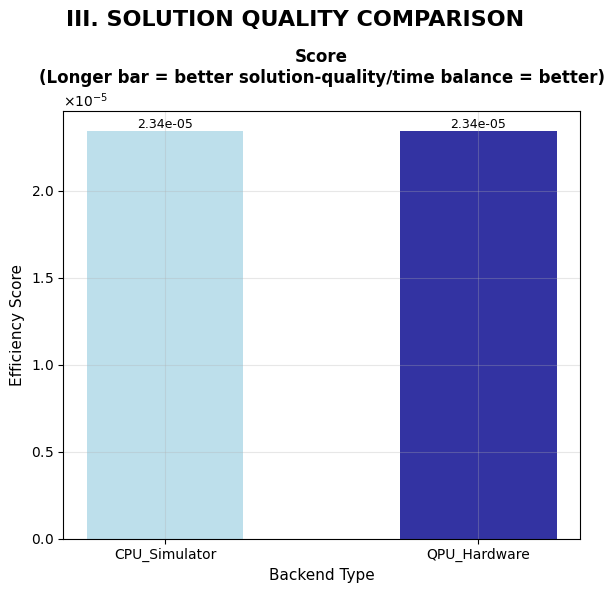

In [22]:
# create visualization
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
fig.suptitle('III. SOLUTION QUALITY COMPARISON', fontsize=16, fontweight='bold')

# extract data from comparison DataFrame
scores = [df_comparison.iloc[0]['score'],
          df_comparison.iloc[1]['score']]

######################################################################################
# plot: efficiency score comparison

x = np.arange(len(backends))

# create bars
bars = axes.bar(x, scores, width=0.5,
               color=['lightblue', 'darkblue'], alpha=0.8)

axes.set_xlabel('Backend Type', fontsize=11)
axes.set_ylabel('Efficiency Score', fontsize=11)
axes.set_title('Score\n(Longer bar = better solution-quality/time balance = better)', fontsize=12, fontweight='bold')
axes.set_xticks(x)
axes.set_xticklabels(backends, rotation=0, ha='center', fontsize=10)
axes.grid(True, alpha=0.3)

axes.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)  # force scientific notation on y-axis

# add value labels on bars (show efficiency scores)
for bar, val in zip(bars, scores):
    height = bar.get_height()
    axes.text(bar.get_x() + bar.get_width()/2., height,
              f'{val:.2e}', ha='center', va='bottom', fontsize=9)

######################################################################################

plt.tight_layout()
plt.show()

### III(c). Conclusion

**Question**: ?

**Answer**: 

## Feasibility

1. **Conclusion I**: ...
2. **Conclusion II**: ...
3. **Conclusion III**: ...

... because:
- ... (Conclusion I)
- ... (Conclusion II)
- ... (Conclusion III)
- ...

# Backend Analysis Conclusion

...